# Simple Color Detection

Kevin J. Walchko, created 15 Jan 2017

---

We want to develop a simple image processing routine that will detect the a given color through a sequence of images.

## References

- [Wikipedia HSV](https://en.wikipedia.org/wiki/HSL_and_HSV)
- [OpenCV Python documentation](http://docs.opencv.org/trunk/d6/d00/tutorial_py_root.html)
- [List of color spaces and their uses](https://en.wikipedia.org/wiki/List_of_color_spaces_and_their_uses)
- [Website to understand RGB and HSV colors](http://colorizer.org/)

## Setup

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import cv2
import jupyter_tools as cvu

## Color Detection

Steps:

1. Convert image from RGB to a better colorspace, here we use HSV
1. Thresholds an image between and upper lower HSV bounds
1. Uses `erode` to first remove small false positives
1. Uses `dilate` to close holes in the image blob.

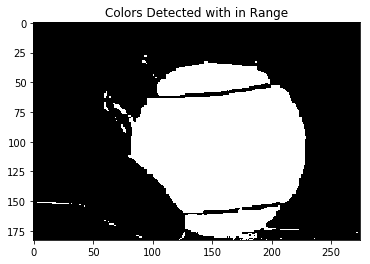

In [27]:
# read in image and convert to HSV
im = cv2.imread('tennis/tennis_test.jpg')
hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

# find colors in ragne
greenLower = (29, 86, 6)
greenUpper = (64, 255, 255)
mask = cv2.inRange(hsv, greenLower, greenUpper)

plt.imshow(mask, cmap='gray')
plt.title('Colors Detected with in Range');

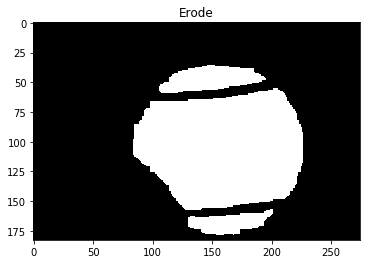

In [28]:
# get rid of stray and noisy pixels
mask = cv2.erode(mask, None, iterations=2)
plt.imshow(mask, cmap='gray')
plt.title('Erode');

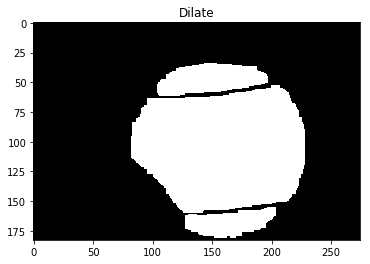

In [29]:
# close up small holes
mask = cv2.dilate(mask, None, iterations=2)
plt.imshow(mask, cmap='gray')
plt.title('Dilate');

Notice in the final image, there are still some detects in the lower right ... nothing is perfect and you typically still have some small left overs to clean up. So let's find things that are circular, since this is a tennis ball and should be round.

In [30]:
# search image for contours
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

print('Found {} objects'.format(len(cnts)))

# find the largest contour in the mask, then use
# it to compute the minimum enclosing circle and
# centroid
c = max(cnts, key=cv2.contourArea)
((x, y), radius) = cv2.minEnclosingCircle(c)
x, y, radius = int(x), int(y), int(radius)
print('Circle center: ({}, {})   radius: {} pixels'.format(x, y, radius))

Found 3 objects
Circle center: (154, 105)   radius: 75 pixels


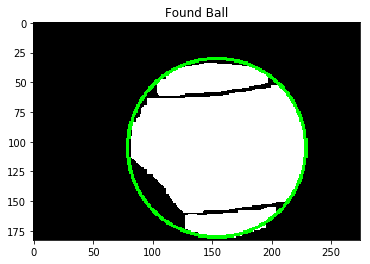

In [34]:
# now convert the image from grayscale back to color so we can
# draw colors on it ... this is only necessary for display
cmask = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)

# draw circle on image
cv2.circle(cmask,(x,y),radius,(0,255,0),2)

plt.imshow(cmask)
plt.title('Found Ball');

# Tennis Ball Finder

Now let's look at it in a class, which will find and mark the tennis ball on an image for us.

In [15]:
class BallDetector(object):
    # hsv colors to threshold on
    greenLower = (29, 86, 6)
    greenUpper = (64, 255, 255)
    diameter = 6.7  # diameter of average tennis ball in cm

    def __init__(self, lower=(29, 86, 6), upper=(64, 255, 255), diameter=6.7):
        """
        Tracks a ball in an image.
        """
        self.greenLower = lower
        self.greenUpper = upper
        self.diameter = diameter

    def distance(self, radius):
        return self.diameter

    def find(self, frame):
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # threshold and find the tennis ball
        mask = cv2.inRange(hsv, self.greenLower, self.greenUpper)

        # do some morphological operators to fill in mask gaps and remove
        # outliers (false positives)
        mask = cv2.erode(mask, None, iterations=2)
        mask = cv2.dilate(mask, None, iterations=2)

        # find contours in the mask
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        center = None
        radius = 0

        # did we find something?
        if len(cnts) > 0:
            # find the largest contour in the mask, then use
            # it to compute the minimum enclosing circle and
            # centroid
            c = max(cnts, key=cv2.contourArea)
            ((x, y), radius) = cv2.minEnclosingCircle(c)

            # only proceed if the radius meets a minimum size
            if radius > 10:
                # find moments -----------
                # M = cv2.moments(c)
                # center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
                # cv2.circle(frame, center, 5, (0, 0, 255), -1)

                # set center and radius of ball
                center = (int(x), int(y))
                radius = int(radius)

        return center, radius

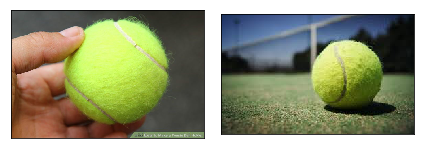

In [16]:
a = cv2.imread('tennis/test6.jpg')
b = cv2.imread('tennis/test3.jpg')
cvu.imshow([a,b]);

In [17]:
bt = BallDetector()

loc = []
for im in [a,b]:
    c, r = bt.find(im)
    cv2.circle(im,c,r,(0,255,0),2)
    cv2.circle(im,c,1,(0,255,0),2)

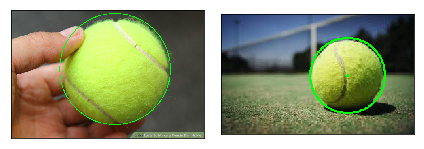

In [18]:
cvu.imshow([a,b]);

Now, for a given situation, you will have to do a lot testing to get the right color bounds. HSV helps with lighting, but there is a limit to how much it will be able to compensate for.


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.